In [1]:
!nvidia-smi

Mon Oct  2 02:01:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 30%   35C    P8    17W / 300W |      1MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q pyspellchecker textstat

In [3]:
!pip install lightgbm==3.3.2 xgboost==1.7.6 catboost==1.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 11.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 12.7 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 76.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.6.2
    Uninstalling xgboost-1.6.2:
      Successfully uninstalled xgboost-1.6.2


In [4]:
import os

class Config:
    AUTHOR = "wanwan7123"

    NAME = "commonlit-exp024-deberta-v3-large"
    MODEL_PATH = "/notebooks/output/commonlit-mlm-deberta-v3-large/model"
    ROOT = "/notebooks"

    apex=True
    seed = 42
    num_fold = 4
    trn_fold = [0, 1, 2, 3]
    batch_size = 16
    n_epochs = 3
    max_len = 1024
    target_list = ["content", "wording"]
    
    weight_decay = 0.01
    scheduler='cosine'
    betas = (0.9, 0.999)
    encoder_lr = 2e-5
    decoder_lr = 3e-5
    lr_weight_decay = 0.98
    min_lr = 1e-6
    eps = 1e-6
    eval_step = 60
    num_cycles=0.5
    num_warmup_steps_rate=0.1
    gradient_accumulation_steps = 1
    
    # GPU Optimize Settings
    gpu_optimize_config= {
        "freezing": True,
        "gradient_checkpoint": True
    }
        
    lgb_model_params = {
        "objective": "rmse",
        "metric": "regression",
        "verbosity": -1,
        "learning_rate": 0.01,
        "random_state": seed,
        "feature_fraction": 0.9
    }
    
    lgb_train_params = {
        "num_boost_round": 999999,
    }
    
        
    xgb_stopping_rounds = 50
    xgb_log_evaluation = False
    xgb_model_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "random_state": seed,
        "learning_rate": 0.01,
        "max_depth": 4,
        "subsample": 0.8,
        "colsample_bytree": 0.4,
        }
    xgb_train_params = {
        "num_boost_round": 99999,
        "verbose_eval": 1000,
    }
    
    cbt_model_params = {
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "iterations": 100000,
        "learning_rate": 0.01,
        "depth": 4,
        "l2_leaf_reg": 10,
        "random_seed": seed,
        "od_type": "Iter",
        "od_wait": 100,
        "verbose": 100,
    }

In [5]:
import os
import re
import gc
import sys
import json
import time
import shutil
import joblib
import random
import requests
import warnings
warnings.filterwarnings('ignore')
from ast import literal_eval
from tqdm.auto import tqdm
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import scipy 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    StratifiedKFold, 
    KFold, 
    GroupKFold,
    StratifiedGroupKFold
)
from sklearn.metrics import mean_squared_error

from spellchecker import SpellChecker
import textstat
import lightgbm as lgb

! pip install torch==1.10.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.checkpoint import checkpoint
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

!pip install text-unidecode

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.4 MB/s eta 0:00:00:00:0100:02m
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu116
    Uninstalling torch-1.12.1+cu116:
      Successfully uninstalled torch-1.12.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu116 requires torch==1.12.1, but you have torch 1.10.1+cu113 which is incompatible.
torchaudio 0.12.1+cu116 requires torch==1.12.1, but you have torch 1.10.1+cu113 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 19.7 MB/s eta 0:00:00


# utils

In [6]:
def setup(cfg):
    cfg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # pip install
    ! pip install -qq transformers==4.16.2
    ! pip install -qq tokenizers==0.11.6
    ! pip install -qq transformers[sentencepiece]

    # set dirs    
    cfg.INPUT = Path(f"{cfg.ROOT}/input")
    cfg.OUTPUT = Path(f"{cfg.ROOT}/output")
    cfg.EXP = cfg.OUTPUT / cfg.NAME

    cfg.api_path = f"{cfg.ROOT}/kaggle.json"

    cfg.EXP_MODEL = cfg.EXP / "model"
    cfg.EXP_FIG = cfg.EXP / "fig"
    cfg.EXP_PREDS = cfg.EXP / "preds"

    # make dirs
    for d in [cfg.EXP, cfg.EXP_MODEL, cfg.EXP_FIG, cfg.EXP_PREDS]:
        d.mkdir(exist_ok=True)
        
    # use kaggle api (need kaggle token)
    f = open(cfg.api_path, 'r')
    json_data = json.load(f) 
    os.environ['KAGGLE_USERNAME'] = json_data['username']
    os.environ['KAGGLE_KEY'] = json_data['key']
    
    return cfg

def dataset_create_new(dataset_name, upload_dir):
    dataset_metadata = {}
    dataset_metadata['id'] = f'{os.environ["KAGGLE_USERNAME"]}/{dataset_name}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = dataset_name
    with open(os.path.join(upload_dir, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode='tar')

In [7]:
# =====================
# Utils
# =====================
# Seed
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# KFold
def get_kfold(train, n_splits, seed):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train)
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_stratifiedkfold(train, target_col, n_splits, seed):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_groupkfold(train, target_col, group_col, n_splits):
    kf = GroupKFold(n_splits=n_splits)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_groupstratifiedkfold(train, target_col, group_col, n_splits, seed):
    kf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_multilabelstratifiedkfold(train, target_col, n_splits, seed):
    kf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_commonlit_fold(train):
    id2fold = {
        "814d6b": 0,
        "39c16e": 1,
        "3b9047": 2,
        "ebad26": 3,
    }
    train["fold"] = train["prompt_id"].map(id2fold)
    return train["fold"]

In [8]:
def mcrmse(cfg, preds, df, verbose = True):
    scores = []
    all_score = 0
    for i, column in enumerate(cfg.target_list):
        score = np.sqrt(mean_squared_error(preds[:, i], df[column]))
        if verbose:
            print(f"{column} rmse:", score)
        all_score += score/len(cfg.target_list)
        scores.append(score)
    return all_score, scores[0], scores[1]

In [9]:
# def mcrmse(cfg, preds, df, verbose = True):
#     all_score = 0
#     for i, column in enumerate(cfg.target_list):
#         score = np.sqrt(mean_squared_error(preds[:, i], df[column]))
#         if verbose:
#             print(f"{column} rmse:", score)
#         all_score += score/len(cfg.target_list)
#     return all_score

# preprocess

In [10]:
from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs

def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

In [11]:
misspell_mapping = {
    'studentdesigned': 'student designed',
    'teacherdesigned': 'teacher designed',
    'genericname': 'generic name',
    'winnertakeall': 'winner take all',
    'studentname': 'student name',
    'driveless': 'driverless',
    'teachername': 'teacher name',
    'propername': 'proper name',
    'bestlaid': 'best laid',
    'genericschool': 'generic school',
    'schoolname': 'school name',
    'winnertakesall': 'winner take all',
    'elctoral': 'electoral',
    'eletoral': 'electoral',
    'genericcity': 'generic city',
    'elctors': 'electoral',
    'venuse': 'venue',
    'blimplike': 'blimp like',
    'selfdriving': 'self driving',
    'electorals': 'electoral',
    'nearrecord': 'near record',
    'egyptianstyle': 'egyptian style',
    'oddnumbered': 'odd numbered',
    'carintensive': 'car intensive',
    'elecoral': 'electoral',
    'oction': 'auction',
    'electroal': 'electoral',
    'evennumbered': 'even numbered',
    'mesalandforms': 'mesa landforms',
    'electoralvote': 'electoral vote',
    'relativename': 'relative name',
    '22euro': 'twenty two euro',
    'ellectoral': 'electoral',
    'thirtyplus': 'thirty plus',
    'collegewon': 'college won',
    'hisher': 'higher',
    'teacherbased': 'teacher based',
    'computeranimated': 'computer animated',
    'canadidate': 'candidate',
    'studentbased': 'student based',
    'gorethanks': 'gore thanks',
    'clouddraped': 'cloud draped',
    'edgarsnyder': 'edgar snyder',
    'emotionrecognition': 'emotion recognition',
    'landfrom': 'land form',
    'fivedays': 'five days',
    'electoal': 'electoral',
    'lanform': 'land form',
    'electral': 'electoral',
    'presidentbut': 'president but',
    'teacherassigned': 'teacher assigned',
    'beacuas': 'because',
    'positionestimating': 'position estimating',
    'selfeducation': 'self education',
    'diverless': 'driverless',
    'computerdriven': 'computer driven',
    'outofcontrol': 'out of control',
    'faultthe': 'fault the',
    'unfairoutdated': 'unfair outdated',
    'aviods': 'avoid',
    'momdad': 'mom dad',
    'statesbig': 'states big',
    'presidentswing': 'president swing',
    'inconclusion': 'in conclusion',
    'handsonlearning': 'hands on learning',
    'electroral': 'electoral',
    'carowner': 'car owner',
    'elecotral': 'electoral',
    'studentassigned': 'student assigned',
    'collegefive': 'college five',
    'presidant': 'president',
    'unfairoutdatedand': 'unfair outdated and',
    'nixonjimmy': 'nixon jimmy',
    'canadates': 'candidate',
    'tabletennis': 'table tennis',
    'himher': 'him her',
    'studentsummerpacketdesigners': 'student summer packet designers',
    'studentdesign': 'student designed',
    'limting': 'limiting',
    'electrol': 'electoral',
    'campaignto': 'campaign to',
    'presendent': 'president',
    'thezebra': 'the zebra',
    'landformation': 'land formation',
    'eyetoeye': 'eye to eye',
    'selfreliance': 'self reliance',
    'studentdriven': 'student driven',
    'winnertake': 'winner take',
    'alliens': 'aliens',
    '2000but': '2000 but',
    'electionto': 'election to',
    'candidatesas': 'candidates as',
    'electers': 'electoral',
    'winnertakes': 'winner takes',
    'isfeet': 'is feet',
    'incar': 'incur',
    'wellconstructed': 'well constructed',
    'craftsmenwomen': 'crafts men women',
    'freelunch': 'free lunch',
    'twothousandrevolutions': 'two thousand revolutions',
    'ushistoryorg': 'us history org',
    'pharohs': 'pharaohs',
    'whitehot': 'white hot',
    'vizers': 'visors',
    'mrjones': 'mr jones',
    'aminute': 'a minute',
    'spoiledmeat': 'spoiled meat',
    'farmersgave': 'farmers gave',
    'spolied': 'spoiled',
    'tradgey': 'tragedy',
    'pyrimid': 'pyramid',
    'pyrimad': 'pyramid',
    'egyptiansfrom': 'egyptians from',
    'harvestthats': 'harvest that',
    'expierment': 'experiment',
    'jestthat': 'jest that',
    'twothousandrevolutionsaminute': 'two thousand revolutions a minute',
    'expirament': 'experiment',
    'nonspoiled': 'non spoiled',
    'egyptains': 'egyptians',
    'tragedys': 'tragedy',
    'pyrmaid': 'pyramid',
    'expirment': 'experiment',
    'whiteit': 'grade there',
    'gradethere': 'tragedy',
    'goverement': 'government',
    'godsthe': 'gods the',
    'paraoh': 'pharaoh',
    'classesupper': 'classes upper',
    'pharoes': 'pharaohs',
    'noblespriests': 'noble priests',
    'farmersslaves': 'farmers slaves',
    'harvestâ€”thatâ€™s': 'harvest that',
    'tradedy': 'tragedy',
    'paraohs': 'pharaohs',
    'paragrapgh': 'paragraph',
    'expieriment': 'experiment',
    'tragdey': 'tragedy',
    'pyramaid': 'pyramid',
    'pyrmid': 'pyramid',
    'prists': 'priests',
    'pharoas': 'pharaohs',
    'priets': 'priests',
    'pharoph': 'pharaohs',
    'pharaoah': 'pharaohs',
    'pharahos': 'pharaohs',
    'pharaohthe': 'pharaohs'
}

In [12]:
def decontraction(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"he's", "he is", phrase)
    phrase = re.sub(r"there's", "there is", phrase)
    phrase = re.sub(r"We're", "We are", phrase)
    phrase = re.sub(r"That's", "That is", phrase)
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"they're", "they are", phrase)
    phrase = re.sub(r"Can't", "Cannot", phrase)
    phrase = re.sub(r"wasn't", "was not", phrase)
    phrase = re.sub(r"don\x89Ûªt", "do not", phrase)
    phrase = re.sub(r"donãât", "do not", phrase)
    phrase = re.sub(r"aren't", "are not", phrase)
    phrase = re.sub(r"isn't", "is not", phrase)
    phrase = re.sub(r"What's", "What is", phrase)
    phrase = re.sub(r"haven't", "have not", phrase)
    phrase = re.sub(r"hasn't", "has not", phrase)
    phrase = re.sub(r"There's", "There is", phrase)
    phrase = re.sub(r"He's", "He is", phrase)
    phrase = re.sub(r"It's", "It is", phrase)
    phrase = re.sub(r"You're", "You are", phrase)
    phrase = re.sub(r"I'M", "I am", phrase)
    phrase = re.sub(r"shouldn't", "should not", phrase)
    phrase = re.sub(r"wouldn't", "would not", phrase)
    phrase = re.sub(r"i'm", "I am", phrase)
    phrase = re.sub(r"I\x89Ûªm", "I am", phrase)
    phrase = re.sub(r"I'm", "I am", phrase)
    phrase = re.sub(r"Isn't", "is not", phrase)
    phrase = re.sub(r"Here's", "Here is", phrase)
    phrase = re.sub(r"you've", "you have", phrase)
    phrase = re.sub(r"you\x89Ûªve", "you have", phrase)
    phrase = re.sub(r"we're", "we are", phrase)
    phrase = re.sub(r"what's", "what is", phrase)
    phrase = re.sub(r"couldn't", "could not", phrase)
    phrase = re.sub(r"we've", "we have", phrase)
    phrase = re.sub(r"it\x89Ûªs", "it is", phrase)
    phrase = re.sub(r"doesn\x89Ûªt", "does not", phrase)
    phrase = re.sub(r"It\x89Ûªs", "It is", phrase)
    phrase = re.sub(r"Here\x89Ûªs", "Here is", phrase)
    phrase = re.sub(r"who's", "who is", phrase)
    phrase = re.sub(r"I\x89Ûªve", "I have", phrase)
    phrase = re.sub(r"y'all", "you all", phrase)
    phrase = re.sub(r"can\x89Ûªt", "cannot", phrase)
    phrase = re.sub(r"would've", "would have", phrase)
    phrase = re.sub(r"it'll", "it will", phrase)
    phrase = re.sub(r"we'll", "we will", phrase)
    phrase = re.sub(r"wouldn\x89Ûªt", "would not", phrase)
    phrase = re.sub(r"We've", "We have", phrase)
    phrase = re.sub(r"he'll", "he will", phrase)
    phrase = re.sub(r"Y'all", "You all", phrase)
    phrase = re.sub(r"Weren't", "Were not", phrase)
    phrase = re.sub(r"Didn't", "Did not", phrase)
    phrase = re.sub(r"they'll", "they will", phrase)
    phrase = re.sub(r"they'd", "they would", phrase)
    phrase = re.sub(r"DON'T", "DO NOT", phrase)
    phrase = re.sub(r"That\x89Ûªs", "That is", phrase)
    phrase = re.sub(r"they've", "they have", phrase)
    phrase = re.sub(r"i'd", "I would", phrase)
    phrase = re.sub(r"should've", "should have", phrase)
    phrase = re.sub(r"You\x89Ûªre", "You are", phrase)
    phrase = re.sub(r"where's", "where is", phrase)
    phrase = re.sub(r"Don\x89Ûªt", "Do not", phrase)
    phrase = re.sub(r"we'd", "we would", phrase)
    phrase = re.sub(r"i'll", "I will", phrase)
    phrase = re.sub(r"weren't", "were not", phrase)
    phrase = re.sub(r"They're", "They are", phrase)
    phrase = re.sub(r"Can\x89Ûªt", "Cannot", phrase)
    phrase = re.sub(r"you\x89Ûªll", "you will", phrase)
    phrase = re.sub(r"I\x89Ûªd", "I would", phrase)
    phrase = re.sub(r"let's", "let us", phrase)
    phrase = re.sub(r"it's", "it is", phrase)
    phrase = re.sub(r"can't", "cannot", phrase)
    phrase = re.sub(r"don't", "do not", phrase)
    phrase = re.sub(r"you're", "you are", phrase)
    phrase = re.sub(r"i've", "I have", phrase)
    phrase = re.sub(r"that's", "that is", phrase)
    phrase = re.sub(r"i'll", "I will", phrase)
    phrase = re.sub(r"doesn't", "does not",phrase)
    phrase = re.sub(r"i'd", "I would", phrase)
    phrase = re.sub(r"didn't", "did not", phrase)
    phrase = re.sub(r"ain't", "am not", phrase)
    phrase = re.sub(r"you'll", "you will", phrase)
    phrase = re.sub(r"I've", "I have", phrase)
    phrase = re.sub(r"Don't", "do not", phrase)
    phrase = re.sub(r"I'll", "I will", phrase)
    phrase = re.sub(r"I'd", "I would", phrase)
    phrase = re.sub(r"Let's", "Let us", phrase)
    phrase = re.sub(r"you'd", "You would", phrase)
    phrase = re.sub(r"It's", "It is", phrase)
    phrase = re.sub(r"Ain't", "am not", phrase)
    phrase = re.sub(r"Haven't", "Have not", phrase)
    phrase = re.sub(r"Could've", "Could have", phrase)
    phrase = re.sub(r"youve", "you have", phrase)  
    phrase = re.sub(r"donå«t", "do not", phrase)
    return phrase

In [13]:
def clean_text(text):
    text = decontraction(text)
    return text

In [14]:
def clean_misspell(text):
    for bad_word in misspell_mapping:
        if bad_word in text:
            text = text.replace(bad_word, misspell_mapping[bad_word])
    return text

In [15]:
def processing_features(df):
    df['processed_text'] = df['text'].apply(lambda x : resolve_encodings_and_normalize(x))
    df['processed_text'] = df['processed_text'].apply(lambda x : clean_text(x))
    df['processed_text'] = df['processed_text'].apply(lambda x : clean_misspell(x))
    df['full_text'] = "content wording" + " [TITLE] " + df["prompt_title"] + " [QUESTION] " + df["prompt_question"] + " [ANSWER] " + df["processed_text"]
    return df

In [16]:
%load_ext Cython

In [17]:
%%cython

import numpy as np
cimport numpy as cnp
cimport cython

@cython.boundscheck(False)  # Arrayの境界チェックを無効化
@cython.wraparound(False)   # 負のインデックスを無効化
def longest_common_substring(str s1, str s2):
    cdef int m, n, i, j, longest
    m, n = len(s1), len(s2)
    
    # Using numpy to initialize the 2D array
    cdef cnp.ndarray[int, ndim=2] dp = np.zeros((m+1, n+1), dtype=np.int32)
    
    longest = 0
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                dp[i, j] = 0
            elif s1[i - 1] == s2[j - 1]:
                dp[i, j] = dp[i - 1, j - 1] + 1
                longest = max(longest, dp[i, j])
            else:
                dp[i, j] = 0
    return longest

In file included from /usr/local/lib/python3.9/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /usr/local/lib/python3.9/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.9/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_0507ba6f7af5325357e70c61fd0cf3f5.c:769:
/usr/local/lib/python3.9/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [18]:
def quotes_count(row):
    text = row['text']
    prompt_text = row['prompt_text']
    quotes_from_text = re.findall(r'"([^"]*)"', text)
    if len(quotes_from_text)>0:
        return [quote in prompt_text for quote in quotes_from_text].count(True)
    else:
        return 0
    
def ngram_co_occurrence(row, n=3):
    text = row["text"]
    prompt_text = row["prompt_text"]

    text_ngram = set(zip(*[text[i:] for i in range(n)]))
    prompt_ngram = set(zip(*[prompt_text[i:] for i in range(n)]))
    return len(text_ngram & prompt_ngram)

def feature_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = pd.DataFrame()

    # basic
    output_df["n_words"] = input_df["text"].apply(lambda x: len(x.split()))
    output_df["n_unique_words"] = input_df["text"].apply(lambda x: len(set(x.split())))
    output_df["num_sentences"] = input_df["text"].apply(lambda x: len(x.split('.')))
    output_df["is_upper"] = input_df["text"].apply(lambda x: x[0].isupper())
    output_df["mean_num_words"] = input_df["text"].apply(lambda x: np.mean([len(e.split()) for e in x.split('.')]))
    output_df["mean_num_unique_words"] = input_df["text"].apply(lambda x: np.mean([len(set(e.split())) for e in x.split('.')]))
    output_df["num_slash"] = input_df["text"].apply(lambda x: x.count("\n"))
    output_df["paragraph_count"] = input_df["text"].apply(lambda x: x.count("\n\n"))
    output_df["upper_count"] = input_df["text"].apply(lambda x: np.sum([w.isupper() for w in x.split()])/len(x.split()))
    output_df["syntax_count"] = input_df["text"].apply(lambda x: x.count(",") + x.count("-") + x.count(";") + x.count(":"))
    output_df["vocab_strength"] = output_df["n_unique_words"] / output_df["n_words"]
    output_df["new_vocab"] = input_df.apply(lambda x: len(set(x["text"].split()) - set(x["prompt_text"].split())), axis=1)

    # compare
    # overwrap word
    output_df["n_overwrap_unique_word"] = input_df.apply(lambda x: len(set(x["text"].split()) & set(x["prompt_text"].split())), axis=1)
    # longest common substring
    output_df["longest_common_substring"] = input_df.apply(lambda x: longest_common_substring(x["text"], x["prompt_text"]), axis=1)
    # quote
    output_df["quote_count"] = input_df.apply(quotes_count, axis=1)
    # ngram co occurrence
    for n in [3, 4, 5, 6, 7, 8]:
        output_df[f"n_co_occurrence_{n}"] = input_df.apply(ngram_co_occurrence, n=n, axis=1) / output_df["n_words"]
    
    
    # misspell
    spell = SpellChecker()
    output_df["n_misspell"] = input_df["text"].apply(lambda x: len(spell.unknown(x.split())))


    output_df['automated_readability_index'] = input_df["text"].apply(lambda x: textstat.automated_readability_index(x))
    output_df['coleman_liau_index'] = input_df["text"].apply(lambda x: textstat.coleman_liau_index(x))
    output_df['smog_index'] = input_df["text"].apply(textstat.smog_index)
    output_df['dale_chall_readability_score'] = input_df["text"].apply(lambda x: textstat.dale_chall_readability_score(x))
    output_df['linsear_write_formula'] = input_df["text"].apply(lambda x: textstat.linsear_write_formula(x))
    output_df['gunning_fog'] = input_df["text"].apply(textstat.gunning_fog)
    output_df['text_standard_float'] = input_df["text"].apply(textstat.text_standard, float_output=True)
    output_df['spache_readability'] = input_df["text"].apply(textstat.spache_readability)
    output_df['rix'] = input_df["text"].apply(textstat.rix)
    output_df['lix'] = input_df["text"].apply(textstat.lix)


    return output_df

# dataset

In [19]:
class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['full_text'].to_numpy()
        self.labels = df[cfg.target_list].to_numpy()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        inputs = self.prepare_input(self.cfg, self.texts[index])
        labels = torch.tensor(self.labels[index], dtype=torch.float)
        return inputs, labels

    @staticmethod
    def prepare_input(cfg, text):
        inputs = cfg.tokenizer(text,
                               add_special_tokens=True,
                               max_length=cfg.max_len,
                               padding="max_length",
                               truncation=True,
                               return_offsets_mapping=False)
        inputs['input_ids'] = torch.tensor(
            inputs['input_ids'],
            dtype=torch.long
        )
        inputs['attention_mask'] = torch.tensor(
            inputs['attention_mask'],
            dtype=torch.long
        )
        inputs = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }
        return inputs

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# model

In [20]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False

class AttentionPooling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(
        nn.Linear(in_dim, in_dim),
        nn.LayerNorm(in_dim),
        nn.GELU(),
        nn.Linear(in_dim, 1),
        )
        
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, last_hidden_state, attention_mask):
        w = self.attention(last_hidden_state).float()
        w[attention_mask==0]=float('-inf')
        w = torch.softmax(w,1)
        attention_embeddings = torch.sum(w * last_hidden_state, dim=1)
        return attention_embeddings

class CustomModel(nn.Module):
    def __init__(self, cfg): 
        super().__init__()
        self.cfg = cfg
        self.gpu_optimize_config = cfg.gpu_optimize_config
        self.config = AutoConfig.from_pretrained(
            cfg.MODEL_PATH,
            output_hidden_states=True
        )
        self.config.update(
            {
                "output_hidden_states": True,
                "hidden_dropout": 0.,
                "hidden_dropout_prob": 0.,
                "attention_dropout": 0.,
                "attention_probs_dropout_prob": 0,
            }
        )
        self.backbone = AutoModel.from_pretrained(
            cfg.MODEL_PATH,
            config=self.config
        )

        self.pool1 = AttentionPooling(self.config.hidden_size)
        self.pool2 = AttentionPooling(self.config.hidden_size)
        self.fc1 = nn.Linear(self.config.hidden_size, 1)
        self.fc2 = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.fc1)
        self._init_weights(self.fc2)
        self.ln1 = nn.LayerNorm(self.config.hidden_size)
        self.ln2 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.ln1)
        self._init_weights(self.ln2)

        # Freeze
        if self.gpu_optimize_config['freezing']:
            freeze(self.backbone.embeddings)
            freeze(self.backbone.encoder.layer[:6])

        # Gradient Checkpointing
        if self.gpu_optimize_config['gradient_checkpoint']:
            self.backbone.gradient_checkpointing_enable()

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, inputs):
        outputs = self.backbone(**inputs)
        last_state = outputs[0]
        feature1 = self.pool1(last_state, inputs['attention_mask'])
        feature2 = self.pool2(last_state, inputs['attention_mask'])
        return feature1, feature2

    def forward(self, inputs, labels):
        # batch, hidden_size
        feature1, feature2 = self.feature(inputs)
        # batch, 2
        output1 = self.fc1(self.ln1(feature1))
        output2 = self.fc2(self.ln2(feature2))
        output = torch.cat((output1, output2), -1)
        if labels is not None:
            loss_fct = nn.SmoothL1Loss(reduction='mean')
            loss = loss_fct(output, labels)
            return loss, output
        else:
            return output

# optimizer, scheduler

In [21]:
def get_optimizer_grouped_parameters(cfg, model):
    model_type = 'backbone'
    no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
    optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if "backbone" not in n],
             'lr': cfg.decoder_lr, 'weight_decay': 0.0},
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = cfg.encoder_lr
    for layer in layers:
        lr *= cfg.lr_weight_decay
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": cfg.weight_decay,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [22]:
def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=int(num_train_steps*cfg.num_warmup_steps_rate), num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=int(num_train_steps*cfg.num_warmup_steps_rate), num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler

# eval,train

In [23]:
def evaluating(cfg, valid_loader, model, valid_df, fold, best_val_preds_c, best_val_preds_w, best_val_score_c, best_val_score_w):
    val_preds = []
    val_losses = []
    val_nums = []
    model.eval()
    with torch.no_grad():
        with tqdm(valid_loader, total=len(valid_loader)) as pbar:
            for (inputs, labels) in pbar:
                inputs = collate(inputs)
                for k, v in inputs.items():
                    inputs[k] = v.to(cfg.device)
                labels = labels.to(cfg.device)
                with autocast():
                    loss, output = model(inputs, labels)
                
                output = output.detach().cpu().numpy()
                val_preds.append(output)
                val_losses.append(loss.item() * len(labels))
                val_nums.append(len(labels))
                pbar.set_postfix({
                    'val_loss': loss.item()
                })

    val_preds = np.concatenate(val_preds)
    val_loss = sum(val_losses) / sum(val_nums)
    score_all, score_c, score_w = mcrmse(cfg, val_preds, valid_df)

    val_log = {
        'val_loss': val_loss,
        'mcrmse': score_all
    }
    display(val_log)

    if best_val_score_c > score_c:
        print('\033[31m'+'save content model weight'+'\033[0m')
        best_val_preds_c = val_preds[:, 0]
        best_val_score_c = score_c
        torch.save(
            model.state_dict(), 
            cfg.EXP_MODEL / f"fold{fold}_c.pth"
        )
        
    if best_val_score_w > score_w:
        print('\033[31m'+'save wording model weight'+'\033[0m')
        best_val_preds_w = val_preds[:, 1]
        best_val_score_w = score_w
        torch.save(
            model.state_dict(), 
            cfg.EXP_MODEL / f"fold{fold}_w.pth"
        )
    
    return best_val_preds_c, best_val_preds_w, best_val_score_c, best_val_score_w

def training(cfg, train):
    # =====================
    # Training
    # =====================
    set_seed(cfg.seed)
    oof_pred = np.zeros((len(train), 2), dtype=np.float32)
    fold_score = []

    for fold in cfg.trn_fold:
        # dataset, dataloader
        train_df = train.loc[cfg.folds!=fold]
        valid_df = train.loc[cfg.folds==fold]
        train_idx = list(train_df.index)
        valid_idx = list(valid_df.index)

        # Datasetの設定
        train_dataset = TrainDataset(cfg, train_df)
        valid_dataset = TrainDataset(cfg, valid_df)
        train_loader = DataLoader(
            dataset=train_dataset, 
            batch_size=cfg.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
        )
        valid_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=cfg.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
        )

        # model
        model = CustomModel(cfg)
        model.backbone.resize_token_embeddings(len(cfg.tokenizer))
        torch.save(model.config, cfg.EXP_MODEL / 'config.pth')
        model = model.to(cfg.device)

        # optimizer, scheduler
        optimizer_grouped_parameters = get_optimizer_grouped_parameters(cfg, model)
        optimizer = AdamW(optimizer_grouped_parameters, lr=cfg.encoder_lr, eps=cfg.eps, betas=cfg.betas, weight_decay=cfg.weight_decay)

        num_train_steps = int(len(train_df) / cfg.batch_size * cfg.n_epochs)
        scheduler = get_scheduler(cfg, optimizer, num_train_steps)

        # model-training
        best_val_preds_c = None
        best_val_score_c = 9999
        best_val_preds_w = None
        best_val_score_w = 9999
        
        for epoch in range(cfg.n_epochs):
            # training
            print(f"# ============ start epoch:{epoch} ============== #")
            train_losses = []
            train_nums = []
            model.train() 
            scaler = GradScaler(enabled=cfg.apex)
            with tqdm(train_loader, total=len(train_loader)) as pbar:
                for step, (inputs, labels) in enumerate(pbar):
                    inputs = collate(inputs)
                    for k, v in inputs.items():
                        inputs[k] = v.to(cfg.device)
                    labels = labels.to(cfg.device)
                    with autocast(enabled=cfg.apex):
                        loss, output = model(inputs, labels)

                    pbar.set_postfix({
                        'loss': loss.item(),
                        'lr': scheduler.get_lr()[0]
                    })
                    train_losses.append(loss.item() * len(labels))
                    train_nums.append(len(labels))

                    if cfg.gradient_accumulation_steps > 1:
                        loss = loss / cfg.gradient_accumulation_steps

                    scaler.scale(loss).backward()
                    
                    # if cfg.clip_grad_norm is not None:
                    #     scaler.unscale_(optimizer)
                    #     torch.nn.utils.clip_grad_norm_(
                    #         model.parameters(),
                    #         cfg.clip_grad_norm
                    #     )
                        
                    if (step+1) % cfg.gradient_accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        scheduler.step()

                    if step % cfg.eval_step == 0 and step != 0:
                        print(f'fold: {fold}, epoch: {epoch}, step: {step}')
                        best_val_preds_c, best_val_preds_w, best_val_score_c, best_val_score_w = evaluating(
                            cfg, valid_loader,
                            model,
                            valid_df,
                            fold,
                            best_val_preds_c,
                            best_val_preds_w,
                            best_val_score_c,
                            best_val_score_w,
                        )
                        model.train()

            train_loss = sum(train_losses)/sum(train_nums)
            train_log = {
                'train_loss':train_loss
            }
            display(train_log)

            # evaluating(epoch)
            print(f'fold: {fold}, epoch: {epoch}, complete')
            best_val_preds_c, best_val_preds_w, best_val_score_c, best_val_score_w = evaluating(
                cfg, valid_loader,
                model,
                valid_df,
                fold,
                best_val_preds_c,
                best_val_preds_w,
                best_val_score_c,
                best_val_score_w,
            )
        
        print(best_val_preds_c.shape)
        print(best_val_preds_w.shape)
        oof_pred[valid_idx, 0] = best_val_preds_c.astype(np.float32)
        oof_pred[valid_idx, 1] = best_val_preds_w.astype(np.float32)
        best_val_preds = np.concatenate([best_val_preds_c, best_val_preds_w], -1)
        np.save(cfg.EXP_PREDS / f'oof_pred_fold{fold}.npy', best_val_preds)
        fold_score.append((best_val_score_c + best_val_score_w)/2)
        del model; gc.collect()

    np.save(cfg.EXP_PREDS / 'oof_pred.npy', oof_pred)

    # =====================
    # scoring
    # =====================
    score, _, _ = mcrmse(cfg, oof_pred, train)
    print('fold score：', fold_score)
    print('CV:', round(score, 4))
    return score

# main

In [24]:
# setup
cfg = setup(Config)

import transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import tokenizers
import sentencepiece
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

# main
train_df = pd.read_csv(cfg.INPUT / "summaries_train.csv").reset_index()
feedback3_pred = pd.read_csv(cfg.INPUT / "pred_feedback3value.csv")
prompts_train_df = pd.read_csv(cfg.INPUT / "prompts_train.csv")

train_df = train_df.merge(prompts_train_df, on="prompt_id")
train_df = processing_features(train_df)
train_df = train_df.sort_values("index").reset_index(drop = True)

train_feat_df = feature_engineering(train_df)
cfg.num_feat_dim = train_feat_df.shape[1]

cfg.tokenizer = AutoTokenizer.from_pretrained("/notebooks/output/commonlit-mlm-deberta-v3-large/tokenizer")
cfg.tokenizer.add_tokens(["[TITLE]", "[QUESTION]", "[ANSWER]"], special_tokens=True)
cfg.tokenizer.save_pretrained(cfg.EXP / 'tokenizer')
cfg.folds = get_commonlit_fold(train_df)
cfg.folds.to_csv(cfg.EXP_PREDS / 'folds.csv')

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.11.6
transformers.__version__: 4.16.2


In [25]:
train_df.loc[0, "full_text"]

'content wording [TITLE] The Third Wave [QUESTION] Summarize how the Third Wave developed over such a short period of time and why the experiment was ended. [ANSWER] The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader'

In [26]:
score = training(cfg, train_df)

Some weights of the model checkpoint at /notebooks/output/commonlit-mlm-deberta-v3-large/model were not used when initializing DebertaV2Model: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/378 [00:00<?, ?it/s]

fold: 0, epoch: 0, step: 60


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.6958863364938793
wording rmse: 0.8138114031631255


{'val_loss': 0.25864788654816767, 'mcrmse': 0.7548488698285024}

save content model weight
save wording model weight
fold: 0, epoch: 0, step: 120


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.563775382695079
wording rmse: 0.7481808927249072


{'val_loss': 0.19898821793138602, 'mcrmse': 0.6559781377099931}

save content model weight
save wording model weight
fold: 0, epoch: 0, step: 180


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.6821981370723121
wording rmse: 0.8151596254987906


{'val_loss': 0.25078744352782517, 'mcrmse': 0.7486788812855514}

fold: 0, epoch: 0, step: 240


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5895145782528536
wording rmse: 0.7596074259396542


{'val_loss': 0.2078571430089143, 'mcrmse': 0.6745610020962539}

fold: 0, epoch: 0, step: 300


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5405921293722943
wording rmse: 0.6828851132724864


{'val_loss': 0.17452266569150543, 'mcrmse': 0.6117386213223903}

save content model weight
save wording model weight
fold: 0, epoch: 0, step: 360


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.509077841914001
wording rmse: 0.683058081762213


{'val_loss': 0.16627762669989551, 'mcrmse': 0.5960679618381071}

save content model weight


{'train_loss': 0.1712132893384449}

fold: 0, epoch: 0, complete


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5175069754404639
wording rmse: 0.6941150876386347


{'val_loss': 0.17156921817514967, 'mcrmse': 0.6058110315395493}

# ============ start epoch:1 ============== #


  0%|          | 0/378 [00:00<?, ?it/s]

fold: 0, epoch: 1, step: 60


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5082152029700064
wording rmse: 0.6779098061560778


{'val_loss': 0.16551060905698636, 'mcrmse': 0.5930625045630421}

save content model weight
save wording model weight
fold: 0, epoch: 1, step: 120


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5435585478699028
wording rmse: 0.7195799565347971


{'val_loss': 0.18542188230364948, 'mcrmse': 0.6315692522023499}

fold: 0, epoch: 1, step: 180


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5380341911371052
wording rmse: 0.6823528790150709


{'val_loss': 0.17275939702123053, 'mcrmse': 0.6101935350760881}

fold: 0, epoch: 1, step: 240


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.549692424104659
wording rmse: 0.6795658117175389


{'val_loss': 0.1755644022229576, 'mcrmse': 0.614629117911099}

fold: 0, epoch: 1, step: 300


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5138719661343831
wording rmse: 0.6874830171612222


{'val_loss': 0.16783508561139526, 'mcrmse': 0.6006774916478026}

fold: 0, epoch: 1, step: 360


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5068759713484804
wording rmse: 0.6654258771190865


{'val_loss': 0.15885183550181003, 'mcrmse': 0.5861509242337835}

save content model weight
save wording model weight


{'train_loss': 0.09285134613198578}

fold: 0, epoch: 1, complete


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.497143088933185
wording rmse: 0.6754755829361574


{'val_loss': 0.16022355795068732, 'mcrmse': 0.5863093359346712}

save content model weight
# ============ start epoch:2 ============== #


  0%|          | 0/378 [00:00<?, ?it/s]

fold: 0, epoch: 2, step: 60


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5515382455642869
wording rmse: 0.6722678261053625


{'val_loss': 0.17295051845008422, 'mcrmse': 0.6119030358348247}

fold: 0, epoch: 2, step: 120


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5566627740644258
wording rmse: 0.6621137841881146


{'val_loss': 0.17153918024419335, 'mcrmse': 0.6093882791262701}

save wording model weight
fold: 0, epoch: 2, step: 180


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.522500587490992
wording rmse: 0.6599047797979686


{'val_loss': 0.16262349525529043, 'mcrmse': 0.5912026836444804}

save wording model weight
fold: 0, epoch: 2, step: 240


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5170623089083877
wording rmse: 0.665499981816086


{'val_loss': 0.16225800967875764, 'mcrmse': 0.5912811453622369}

fold: 0, epoch: 2, step: 300


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.530208576853945
wording rmse: 0.6652581505961557


{'val_loss': 0.16481467863968688, 'mcrmse': 0.5977333637250504}

fold: 0, epoch: 2, step: 360


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5274745824666269
wording rmse: 0.6666838514337537


{'val_loss': 0.1643076527961686, 'mcrmse': 0.5970792169501904}

{'train_loss': 0.06177026952404982}

fold: 0, epoch: 2, complete


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5276881896794132
wording rmse: 0.6665975403010048


{'val_loss': 0.16434810589576784, 'mcrmse': 0.5971428649902091}

(1103,)
(1103,)


Some weights of the model checkpoint at /notebooks/output/commonlit-mlm-deberta-v3-large/model were not used when initializing DebertaV2Model: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/319 [00:00<?, ?it/s]

fold: 1, epoch: 0, step: 60


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.5863255221157311
wording rmse: 0.6845682451543909


{'val_loss': 0.19235279467219454, 'mcrmse': 0.635446883635061}

save content model weight
save wording model weight
fold: 1, epoch: 0, step: 120


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4473268280008817
wording rmse: 0.6654052551049641


{'val_loss': 0.15639748712245505, 'mcrmse': 0.5563660415529229}

save content model weight
save wording model weight
fold: 1, epoch: 0, step: 180


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.5251035441757034
wording rmse: 0.6389315849934438


{'val_loss': 0.16659563244490236, 'mcrmse': 0.5820175645845735}

save wording model weight
fold: 1, epoch: 0, step: 240


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.44305537647526805
wording rmse: 0.6096874632253676


{'val_loss': 0.1352341110135782, 'mcrmse': 0.5263714198503178}

save content model weight
save wording model weight
fold: 1, epoch: 0, step: 300


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.40767663501979884
wording rmse: 0.649967030006819


{'val_loss': 0.14388238970058082, 'mcrmse': 0.5288218325133089}

save content model weight


{'train_loss': 0.18468171960694663}

fold: 1, epoch: 0, complete


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.39647427784787076
wording rmse: 0.6991055694762044


{'val_loss': 0.1575939192187166, 'mcrmse': 0.5477899236620376}

save content model weight
# ============ start epoch:1 ============== #


  0%|          | 0/319 [00:00<?, ?it/s]

fold: 1, epoch: 1, step: 60


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.3960022201945699
wording rmse: 0.5344440665925976


{'val_loss': 0.1085542581566167, 'mcrmse': 0.4652231433935837}

save content model weight
save wording model weight
fold: 1, epoch: 1, step: 120


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.407878547176324
wording rmse: 0.5252775251942182


{'val_loss': 0.10842055602811411, 'mcrmse': 0.4665780361852711}

save wording model weight
fold: 1, epoch: 1, step: 180


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.41934938039719777
wording rmse: 0.6673425039423309


{'val_loss': 0.15141286345639737, 'mcrmse': 0.5433459421697643}

fold: 1, epoch: 1, step: 240


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.39184889373993764
wording rmse: 0.6605317255171534


{'val_loss': 0.143893837812866, 'mcrmse': 0.5261903096285455}

save content model weight
fold: 1, epoch: 1, step: 300


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.422239715910041
wording rmse: 0.5471508421498226


{'val_loss': 0.11686510518808996, 'mcrmse': 0.4846952790299318}

{'train_loss': 0.10057101773571071}

fold: 1, epoch: 1, complete


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4474444985293181
wording rmse: 0.5415930964522147


{'val_loss': 0.12122688505130308, 'mcrmse': 0.4945187974907664}

# ============ start epoch:2 ============== #


  0%|          | 0/319 [00:00<?, ?it/s]

fold: 1, epoch: 2, step: 60


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.3941361342854709
wording rmse: 0.5642139225477679


{'val_loss': 0.11644623898364527, 'mcrmse': 0.4791750284166194}

fold: 1, epoch: 2, step: 120


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.3954699270311055
wording rmse: 0.5853811049848505


{'val_loss': 0.12237956566490707, 'mcrmse': 0.490425516007978}

fold: 1, epoch: 2, step: 180


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.39764091294005055
wording rmse: 0.6104251633588053


{'val_loss': 0.13003726423829867, 'mcrmse': 0.5040330381494279}

fold: 1, epoch: 2, step: 240


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.39736756178139243
wording rmse: 0.5655709861876402


{'val_loss': 0.11730078398804672, 'mcrmse': 0.48146927398451633}

fold: 1, epoch: 2, step: 300


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.3994246704017958
wording rmse: 0.5708611585581


{'val_loss': 0.1191709371999913, 'mcrmse': 0.48514291447994795}

{'train_loss': 0.0673812435922391}

fold: 1, epoch: 2, complete


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.39947165847510596
wording rmse: 0.5711667362035884


{'val_loss': 0.11926435543370004, 'mcrmse': 0.48531919733934714}

(2057,)
(2057,)


Some weights of the model checkpoint at /notebooks/output/commonlit-mlm-deberta-v3-large/model were not used when initializing DebertaV2Model: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/322 [00:00<?, ?it/s]

fold: 2, epoch: 0, step: 60


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6920820365977174
wording rmse: 0.808429162703609


{'val_loss': 0.2600460944668519, 'mcrmse': 0.7502555996506632}

save content model weight
save wording model weight
fold: 2, epoch: 0, step: 120


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 1.0619667322303998
wording rmse: 1.231236819982766


{'val_loss': 0.5571434261669502, 'mcrmse': 1.146601776106583}

fold: 2, epoch: 0, step: 180


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.8889749126031964
wording rmse: 1.0808413028337245


{'val_loss': 0.42117365515309224, 'mcrmse': 0.9849081077184605}

fold: 2, epoch: 0, step: 240


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6174028722741977
wording rmse: 1.0088484849720272


{'val_loss': 0.30309445041590155, 'mcrmse': 0.8131256786231125}

save content model weight
fold: 2, epoch: 0, step: 300


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6916601726804057
wording rmse: 0.9013022170442962


{'val_loss': 0.28311228245170394, 'mcrmse': 0.7964811948623509}

{'train_loss': 0.15950823911922687}

fold: 2, epoch: 0, complete


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.8976573501971448
wording rmse: 1.2098436624115665


{'val_loss': 0.46992160288655027, 'mcrmse': 1.0537505063043557}

# ============ start epoch:1 ============== #


  0%|          | 0/322 [00:00<?, ?it/s]

fold: 2, epoch: 1, step: 60


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.7202608952334559
wording rmse: 0.8481173190464858


{'val_loss': 0.26924656897471755, 'mcrmse': 0.7841891071399709}

fold: 2, epoch: 1, step: 120


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5553362843158607
wording rmse: 0.7438599090236783


{'val_loss': 0.1939567661292076, 'mcrmse': 0.6495980966697694}

save content model weight
save wording model weight
fold: 2, epoch: 1, step: 180


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.7033232298299327
wording rmse: 0.9325356147354475


{'val_loss': 0.2924851425448243, 'mcrmse': 0.81792942228269}

fold: 2, epoch: 1, step: 240


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.608416652612518
wording rmse: 0.9254599599125823


{'val_loss': 0.2640706874011108, 'mcrmse': 0.7669383062625501}

fold: 2, epoch: 1, step: 300


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6679580072062368
wording rmse: 0.9287734579949024


{'val_loss': 0.2826600792790421, 'mcrmse': 0.7983657326005695}

{'train_loss': 0.09166330722687037}

fold: 2, epoch: 1, complete


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5770851472331876
wording rmse: 0.8715377687117702


{'val_loss': 0.2359083804467414, 'mcrmse': 0.724311457972479}

# ============ start epoch:2 ============== #


  0%|          | 0/322 [00:00<?, ?it/s]

fold: 2, epoch: 2, step: 60


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6004648511254704
wording rmse: 0.9170486853511635


{'val_loss': 0.25704899881611776, 'mcrmse': 0.758756768238317}

fold: 2, epoch: 2, step: 120


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5682218629288713
wording rmse: 0.9273682109772564


{'val_loss': 0.2494480444972286, 'mcrmse': 0.7477950369530639}

fold: 2, epoch: 2, step: 180


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6448774353604255
wording rmse: 0.9182215342835234


{'val_loss': 0.2677305337206649, 'mcrmse': 0.7815494848219744}

fold: 2, epoch: 2, step: 240


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5944142723178375
wording rmse: 0.8997943774183053


{'val_loss': 0.24915008340726272, 'mcrmse': 0.7471043248680713}

fold: 2, epoch: 2, step: 300


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6003032957581165
wording rmse: 0.9152596109286771


{'val_loss': 0.2559213703169106, 'mcrmse': 0.7577814533433969}

{'train_loss': 0.060545151347514266}

fold: 2, epoch: 2, complete


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5996164956557509
wording rmse: 0.914750556504487


{'val_loss': 0.2555544358089885, 'mcrmse': 0.757183526080119}

(2009,)
(2009,)


Some weights of the model checkpoint at /notebooks/output/commonlit-mlm-deberta-v3-large/model were not used when initializing DebertaV2Model: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/323 [00:00<?, ?it/s]

fold: 3, epoch: 0, step: 60


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.7960094111517896
wording rmse: 0.9412934018755222


{'val_loss': 0.3461763744124908, 'mcrmse': 0.8686514065136559}

save content model weight
save wording model weight
fold: 3, epoch: 0, step: 120


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.44966313124305973
wording rmse: 0.661933584697344


{'val_loss': 0.15159484857547736, 'mcrmse': 0.5557983579702018}

save content model weight
save wording model weight
fold: 3, epoch: 0, step: 180


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.49520398335241317
wording rmse: 0.7566117009927572


{'val_loss': 0.19196081585540084, 'mcrmse': 0.6259078421725852}

fold: 3, epoch: 0, step: 240


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4796389461759745
wording rmse: 0.5926426346111398


{'val_loss': 0.1411749390896432, 'mcrmse': 0.5361407903935571}

save wording model weight
fold: 3, epoch: 0, step: 300


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.5038516519555989
wording rmse: 0.6315961744488702


{'val_loss': 0.1574432665336586, 'mcrmse': 0.5677239132022345}

{'train_loss': 0.17949633895428188}

fold: 3, epoch: 0, complete


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.47052953331425484
wording rmse: 0.5798651356226808


{'val_loss': 0.13609091343287236, 'mcrmse': 0.5251973344684678}

save wording model weight
# ============ start epoch:1 ============== #


  0%|          | 0/323 [00:00<?, ?it/s]

fold: 3, epoch: 1, step: 60


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4480253699448863
wording rmse: 0.5604867788581741


{'val_loss': 0.12421704916832203, 'mcrmse': 0.5042560744015302}

save content model weight
save wording model weight
fold: 3, epoch: 1, step: 120


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.5023084742704798
wording rmse: 0.7105725202760605


{'val_loss': 0.18305068240614836, 'mcrmse': 0.6064404972732702}

fold: 3, epoch: 1, step: 180


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4407060862049242
wording rmse: 0.5471229543211421


{'val_loss': 0.12102277768040468, 'mcrmse': 0.4939145202630332}

save content model weight
save wording model weight
fold: 3, epoch: 1, step: 240


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.444195586034744
wording rmse: 0.5545337733950098


{'val_loss': 0.12378724134398367, 'mcrmse': 0.49936467971487686}

fold: 3, epoch: 1, step: 300


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4342148168375555
wording rmse: 0.5255251661024817


{'val_loss': 0.11433217687931711, 'mcrmse': 0.4798699914700186}

save content model weight
save wording model weight


{'train_loss': 0.10273970940349272}

fold: 3, epoch: 1, complete


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.46745840005016026
wording rmse: 0.6419047629472662


{'val_loss': 0.15123825472497748, 'mcrmse': 0.5546815814987132}

# ============ start epoch:2 ============== #


  0%|          | 0/323 [00:00<?, ?it/s]

fold: 3, epoch: 2, step: 60


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.43629976128050224
wording rmse: 0.5492126771046183


{'val_loss': 0.1207500552247187, 'mcrmse': 0.4927562191925603}

fold: 3, epoch: 2, step: 120


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4380280773507908
wording rmse: 0.5442794097979288


{'val_loss': 0.11972266605836834, 'mcrmse': 0.4911537435743598}

fold: 3, epoch: 2, step: 180


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4388557292646228
wording rmse: 0.56621433568751


{'val_loss': 0.12556145331245624, 'mcrmse': 0.5025350324760665}

fold: 3, epoch: 2, step: 240


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4415286642690994
wording rmse: 0.5548888399557445


{'val_loss': 0.1229909860299441, 'mcrmse': 0.49820875211242194}

fold: 3, epoch: 2, step: 300


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4401725814058982
wording rmse: 0.5538248533089507


{'val_loss': 0.12250086529281191, 'mcrmse': 0.49699871735742446}

{'train_loss': 0.06587520144856751}

fold: 3, epoch: 2, complete


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4402033636563977
wording rmse: 0.5537817770383614


{'val_loss': 0.12249540767533507, 'mcrmse': 0.49699257034737954}

(1996,)
(1996,)
content rmse: 0.47023835392417007
wording rmse: 0.615089635938683
fold score： [0.5785239343655768, 0.45856320946707796, 0.6495980966697694, 0.4798699914700186]
CV: 0.5427


In [27]:
oof = np.load(cfg.EXP_PREDS / "oof_pred.npy")

In [28]:
feedback3_pred = feedback3_pred.drop('prompt_id', axis = 1)
feedback3_pred.head()

,student_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,000e8c3c7ddb,2.396729,2.672852,2.837891,2.824707,3.123535,2.683594
1,0020ae56ffbf,2.030029,2.591553,2.833984,2.641113,3.173828,3.090332
2,004e978e639e,3.397461,3.453125,3.900391,3.691406,3.817871,3.704102
3,005ab0199905,1.791992,2.041748,2.305664,1.999512,2.478516,2.051514
4,0070c9e7af47,3.356934,3.525879,3.588379,3.570801,3.838867,3.120117


In [29]:
train_df = train_df.merge(feedback3_pred, on="student_id")
train_df.head()

,index,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,processed_text,full_text,fold,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The third wave was an experimentto see how peo...,content wording [TITLE] The Third Wave [QUESTI...,0,2.396729,2.672852,2.837891,2.824707,3.123535,2.683594
1,1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",They would rub it up with soda to make the sme...,content wording [TITLE] Excerpt from The Jungl...,3,2.030029,2.591553,2.833984,2.641113,3.173828,3.090332
2,2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,"In Egypt, there were many occupations and soci...",content wording [TITLE] Egyptian Social Struct...,2,3.397461,3.453125,3.900391,3.691406,3.817871,3.704102
3,3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,The highest class was Pharaohs these people we...,content wording [TITLE] Egyptian Social Struct...,2,1.791992,2.041748,2.305664,1.999512,2.478516,2.051514
4,4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The Third Wave developed rapidly because the ...,content wording [TITLE] The Third Wave [QUESTI...,0,3.356934,3.525879,3.588379,3.570801,3.838867,3.120117


# lightgbm

In [30]:
bert_cols = [f"pred_{i}" for i in cfg.target_list]
train_feat_df[bert_cols] = oof

feedback3_cols = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
train_feat_df[feedback3_cols] = train_df[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

display(train_feat_df.head(1))

,n_words,n_unique_words,num_sentences,is_upper,mean_num_words,mean_num_unique_words,num_slash,paragraph_count,upper_count,syntax_count,...,rix,lix,pred_content,pred_wording,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,61,51,4,True,15.25,15.0,0,0,0.0,0,...,3.0,36.61,-0.040558,0.873535,2.396729,2.672852,2.837891,2.824707,3.123535,2.683594


In [31]:
import pickle
oof_pred_lgbm = np.zeros((len(train_feat_df), 2), dtype=np.float32)
models = []

def training_lgbm(cfg, train_feat_df, target_df):
    for fold in range(cfg.num_fold):
        print("="*30, f"Fold {fold}", "="*30)
        X_train = train_feat_df.loc[cfg.folds!=fold]
        X_valid = train_feat_df.loc[cfg.folds==fold]
        train_idx = list(X_train.index)
        valid_idx = list(X_valid.index)
        
        print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")
        for i, target in enumerate(cfg.target_list):
            y_train = target_df.iloc[train_idx][target].reset_index(drop=True)
            y_valid = target_df.iloc[valid_idx][target].reset_index(drop=True)

            train_dataset = lgb.Dataset(X_train, y_train)
            valid_dataset = lgb.Dataset(X_valid, y_valid)

            model = lgb.train(
                params=cfg.lgb_model_params,
                train_set=train_dataset,
                valid_sets=[train_dataset, valid_dataset],
                callbacks=[
                    lgb.early_stopping(100),
                    lgb.log_evaluation(1000)
                    ],
                **cfg.lgb_train_params
            )
            models.append(model)
            pickle.dump(model, open(cfg.EXP_MODEL /  f"lgbm_fold{fold}_{target}.pkl", "wb"))

            oof_pred_lgbm[valid_idx, i] = model.predict(X_valid)

            score = np.sqrt(mean_squared_error(y_valid, oof_pred_lgbm[valid_idx, i]))

            print(f"Fold {fold} Target {target} RMSE: {score:.4f}")

    pickle.dump(oof_pred_lgbm, open(cfg.EXP_PREDS /  f"oof_lgbm.pkl", "wb"))
    score, _, _ = mcrmse(cfg, oof_pred_lgbm, target_df, verbose = True)
    print(f"Overall RMSE: {score:.5f}")

In [32]:
training_lgbm(cfg, train_feat_df, train_df[cfg.target_list])

============================== Fold 0 ==============================
Train: (6062, 40), Valid: (1103, 40)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[613]	training's l2: 0.0954332	valid_1's l2: 0.214504
Fold 0 Target content RMSE: 0.4631
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[573]	training's l2: 0.161155	valid_1's l2: 0.373786
Fold 0 Target wording RMSE: 0.6114
============================== Fold 1 ==============================
Train: (5108, 40), Valid: (2057, 40)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	training's l2: 0.145273	valid_1's l2: 0.144919
Fold 1 Target content RMSE: 0.3807
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[283]	training's l2: 0.213274	valid_1's l2: 0.251614
Fold 1 Target wording RMSE: 0.5016
============================== Fold 2 =========

<AxesSubplot: xlabel='importance', ylabel='feature'>

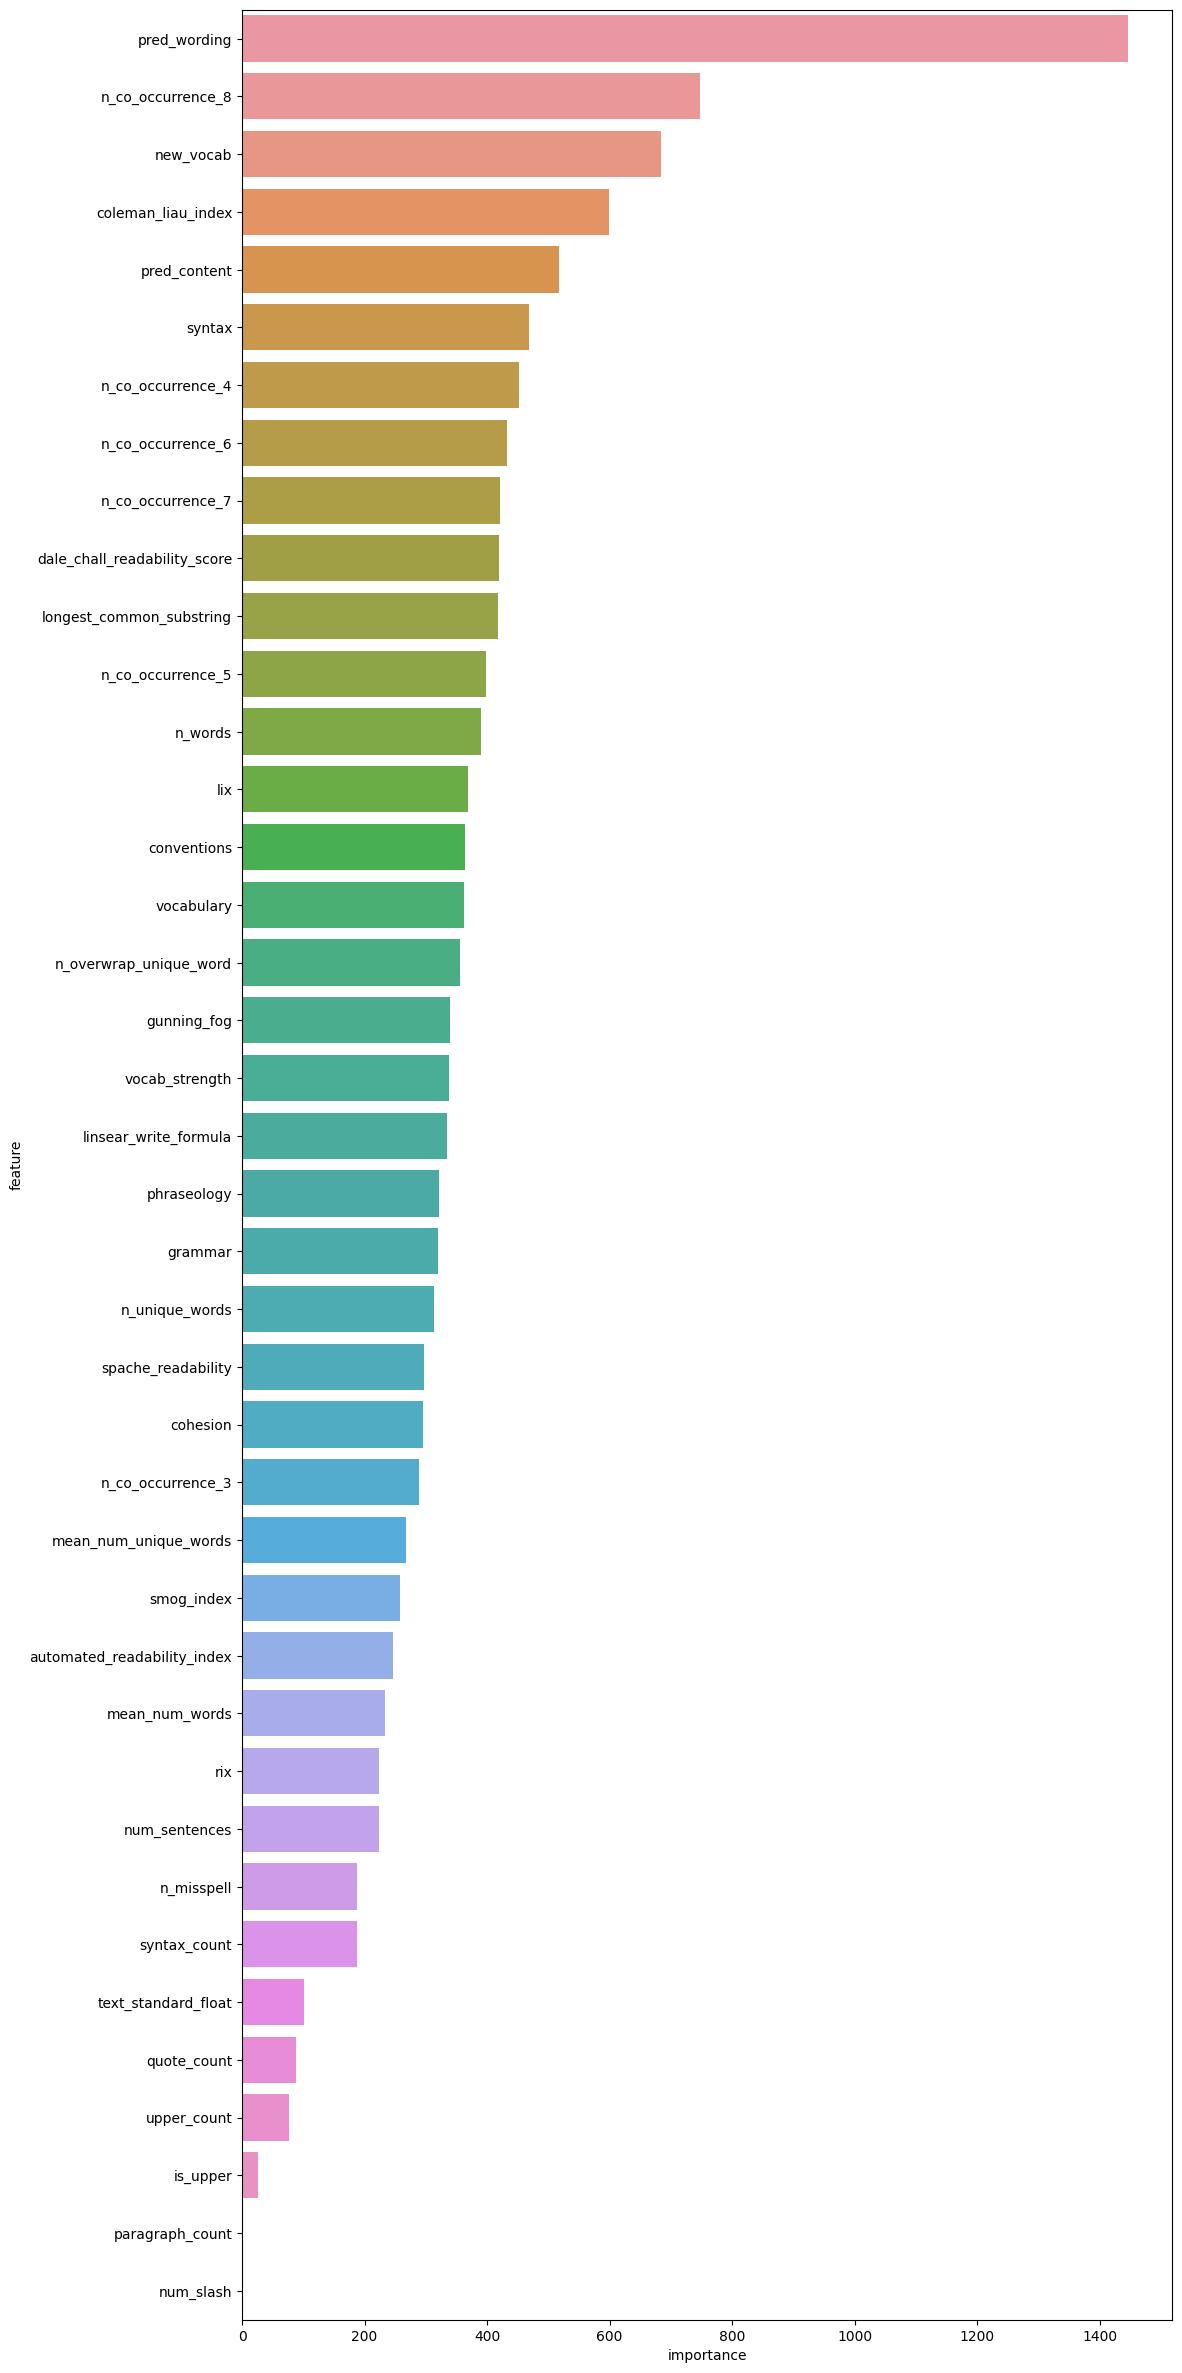

In [33]:
importance_df = pd.DataFrame()
for fold in range(cfg.num_fold):
    model = pickle.load(open(cfg.EXP_MODEL / f"lgbm_fold{fold}_wording.pkl", "rb"))
    _df = pd.DataFrame()
    _df["feature"] = model.feature_name()
    _df["importance"] = model.feature_importance()
    _df["fold"] = fold
    importance_df = pd.concat([importance_df, _df], axis=0)

importance_df.groupby("feature").agg({"importance": ["mean", "std"]}).sort_values(("importance", "mean"), ascending=False)

fig, ax = plt.subplots(figsize=(12, 30))
sns.barplot(x="importance", y="feature", data=importance_df.groupby("feature").agg({"importance": "mean"}).reset_index().sort_values("importance", ascending=False), ax=ax)

# xgboost

In [34]:
import xgboost as xgb
oof_pred_xgb = np.zeros((len(train_feat_df), 2), dtype=np.float32)
models = []

def training_xgb(cfg, train_feat_df, target_df):
    for fold in range(cfg.num_fold):
        print("="*30, f"Fold {fold}", "="*30)
        X_train = train_feat_df.loc[cfg.folds!=fold]
        X_valid = train_feat_df.loc[cfg.folds==fold]
        train_idx = list(X_train.index)
        valid_idx = list(X_valid.index)
        
        print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")
        for i, target in enumerate(cfg.target_list):
            y_train = target_df.iloc[train_idx][target].reset_index(drop=True)
            y_valid = target_df.iloc[valid_idx][target].reset_index(drop=True)

            train_dataset = xgb.DMatrix(X_train, label=y_train)
            valid_dataset = xgb.DMatrix(X_valid, label=y_valid)

            model = xgb.train(
                cfg.xgb_model_params,
                train_dataset,
                evals=[(train_dataset, "train"), (valid_dataset, "valid")],
                callbacks=[
                    xgb.callback.EarlyStopping(
                        cfg.xgb_stopping_rounds,
                        save_best=True,
                        maximize=False,
                    )
                ],
                **cfg.xgb_train_params,
            )
            models.append(model)
            pickle.dump(model, open(cfg.EXP_MODEL /  f"xgb_fold{fold}_{target}.pkl", "wb"))

            oof_pred_xgb[valid_idx, i] = model.predict(valid_dataset)

            score = np.sqrt(mean_squared_error(y_valid, oof_pred_xgb[valid_idx, i]))

            print(f"Fold {fold} Target {target} RMSE: {score:.4f}")

    pickle.dump(oof_pred_xgb, open(cfg.EXP_PREDS /  f"oof_xgb.pkl", "wb"))
    score, _, _ = mcrmse(cfg, oof_pred_xgb, target_df, verbose = True)
    print(f"Overall RMSE: {score:.5f}")

In [35]:
training_xgb(cfg, train_feat_df, train_df[cfg.target_list])

============================== Fold 0 ==============================
Train: (6062, 40), Valid: (1103, 40)
[0]	train-rmse:1.15118	valid-rmse:1.16779
[701]	train-rmse:0.34787	valid-rmse:0.45655
Fold 0 Target content RMSE: 0.4555
[0]	train-rmse:1.18254	valid-rmse:1.10119
[1000]	train-rmse:0.43538	valid-rmse:0.64349
[1260]	train-rmse:0.42205	valid-rmse:0.64152
Fold 0 Target wording RMSE: 0.6412
============================== Fold 1 ==============================
Train: (5108, 40), Valid: (2057, 40)
[0]	train-rmse:1.16383	valid-rmse:1.12717
[324]	train-rmse:0.38947	valid-rmse:0.38155
Fold 1 Target content RMSE: 0.3809
[0]	train-rmse:1.14774	valid-rmse:1.22572
[416]	train-rmse:0.48996	valid-rmse:0.51658
Fold 1 Target wording RMSE: 0.5161
============================== Fold 2 ==============================
Train: (5156, 40), Valid: (2009, 40)
[0]	train-rmse:1.14153	valid-rmse:1.18483
[827]	train-rmse:0.33130	valid-rmse:0.45472
Fold 2 Target content RMSE: 0.4545
[0]	train-rmse:1.19614	valid-rm

# catboost

In [38]:
import catboost as cbt
oof_pred_cbt = np.zeros((len(train_feat_df), 2), dtype=np.float32)
models = []

def training_cbt(cfg, train_feat_df, target_df):
    for fold in range(cfg.num_fold):
        print("="*30, f"Fold {fold}", "="*30)
        X_train = train_feat_df.loc[cfg.folds!=fold]
        X_valid = train_feat_df.loc[cfg.folds==fold]
        train_idx = list(X_train.index)
        valid_idx = list(X_valid.index)
        
        print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")
        for i, target in enumerate(cfg.target_list):
            y_train = target_df.iloc[train_idx][target].reset_index(drop=True)
            y_valid = target_df.iloc[valid_idx][target].reset_index(drop=True)
            
            train_dataset = cbt.Pool(X_train, label=y_train)
            valid_dataset = cbt.Pool(X_valid, label=y_valid)

            model = cbt.train(
                params=cfg.cbt_model_params,
                dtrain=train_dataset,
                evals=valid_dataset,
                # **self.train_params,
            )
            models.append(model)
            pickle.dump(model, open(cfg.EXP_MODEL /  f"cbt_fold{fold}_{target}.pkl", "wb"))

            oof_pred_cbt[valid_idx, i] = model.predict(valid_dataset)

            score = np.sqrt(mean_squared_error(y_valid, oof_pred_cbt[valid_idx, i]))

            print(f"Fold {fold} Target {target} RMSE: {score:.4f}")

    pickle.dump(oof_pred_cbt, open(cfg.EXP_PREDS /  f"oof_cbt.pkl", "wb"))
    score, _, _ = mcrmse(cfg, oof_pred_cbt, target_df, verbose = True)
    print(f"Overall RMSE: {score:.5f}")

In [39]:
training_cbt(cfg, train_feat_df, train_df[cfg.target_list])

============================== Fold 0 ==============================
Train: (6062, 40), Valid: (1103, 40)
0:	learn: 1.0176969	test: 1.1328129	best: 1.1328129 (0)	total: 47.5ms	remaining: 1h 19m 8s
100:	learn: 0.5776241	test: 0.6782117	best: 0.6782117 (100)	total: 159ms	remaining: 2m 37s
200:	learn: 0.4489695	test: 0.5290273	best: 0.5290273 (200)	total: 265ms	remaining: 2m 11s
300:	learn: 0.4122611	test: 0.4819507	best: 0.4819507 (300)	total: 373ms	remaining: 2m 3s
400:	learn: 0.3992049	test: 0.4654209	best: 0.4654209 (400)	total: 477ms	remaining: 1m 58s
500:	learn: 0.3935360	test: 0.4584702	best: 0.4584702 (500)	total: 581ms	remaining: 1m 55s
600:	learn: 0.3899358	test: 0.4556596	best: 0.4556596 (600)	total: 684ms	remaining: 1m 53s
700:	learn: 0.3874250	test: 0.4543961	best: 0.4543961 (700)	total: 783ms	remaining: 1m 50s
800:	learn: 0.3853846	test: 0.4534783	best: 0.4534783 (800)	total: 894ms	remaining: 1m 50s
900:	learn: 0.3836064	test: 0.4527644	best: 0.4527636 (899)	total: 1s	remain

# nelder-mead

In [40]:
from scipy.optimize import minimize

In [43]:
lgb_oof = pickle.load(open(cfg.EXP_PREDS / "oof_lgbm.pkl", "rb"))
xgb_oof = pickle.load(open(cfg.EXP_PREDS / "oof_xgb.pkl", "rb"))
cbt_oof = pickle.load(open(cfg.EXP_PREDS / "oof_cbt.pkl", "rb"))

In [47]:
oof_preds = np.stack([lgb_oof, xgb_oof, cbt_oof], axis=1)

In [50]:
content_pred = oof_val_preds[:, :, 0]
wording_pred = oof_val_preds[:, :, 1]

In [53]:
# def metric
target_col = ['content']

def loss(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))
    
def func(weights):
    pred = np.average(content_pred, axis=1, weights=weights)
    score = loss(train_df[target_col].values, pred)
    return score

model_num = content_pred.shape[1]
# 初期値
initial_weights = np.ones(model_num)/model_num
res = minimize(func, initial_weights, method='Nelder-Mead')

# CV, weight
print(res['fun'], res['x'])

np.save(cfg.EXP_PREDS / "content_weight.npy", res['x'])

0.4185881623878993 [-0.03560153  0.37704621  0.5571297 ]


In [55]:
# def metric
target_col = ['wording']

def loss(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))
    
def func(weights):
    pred = np.average(wording_pred, axis=1, weights=weights)
    score = loss(train_df[target_col].values, pred)
    return score

model_num = wording_pred.shape[1]
# 初期値
initial_weights = np.ones(model_num)/model_num
res = minimize(func, initial_weights, method='Nelder-Mead')

# CV, weight
print(res['fun'], res['x'])

np.save(cfg.EXP_PREDS / "wording_weight.npy", res['x'])

0.5533710325603608 [0.2393748  0.31763175 0.41734212]


In [56]:
(0.4185881623878993 + 0.5533710325603608)/2

0.48597959747413005

In [34]:
!pip install -qq kaggle
from pathlib import PosixPath
from kaggle.api.kaggle_api_extended import KaggleApi
dataset_create_new(dataset_name="commonlit2-pretrained-debertav3large", upload_dir="/notebooks/output/commonlit-mlm-deberta-v3-large")

Starting upload for file tokenizer.tar


100%|██████████| 2.36M/2.36M [00:00<00:00, 4.98MB/s]


Upload successful: tokenizer.tar (2MB)
Starting upload for file model.tar


100%|██████████| 1.62G/1.62G [00:12<00:00, 141MB/s] 


Upload successful: model.tar (2GB)
Starting upload for file corpus.txt


100%|██████████| 16.5M/16.5M [00:00<00:00, 30.6MB/s]


Upload successful: corpus.txt (16MB)
Starting upload for file .ipynb_checkpoints.tar


100%|██████████| 10.0k/10.0k [00:00<00:00, 16.1kB/s]


Upload successful: .ipynb_checkpoints.tar (10KB)
